# Introducing the Keras Sequential API

**Learning Objectives**
  1. Build a DNN model using the Keras Sequential API
  1. Learn how to train a model with Keras
  1. Learn how to save/load, and deploy a Keras model on GCP
  1. Learn how to deploy and make predictions with the Keras model

## Introduction

The [Keras sequential API](https://keras.io/models/sequential/) allows you to create Tensorflow models layer-by-layer. This is useful for building most kinds of machine learning models but it does not allow you to create models that share layers, re-use layers or have multiple inputs or outputs. 

In this lab, we'll see how to build a simple deep neural network model using the Keras sequential api. Once we have trained our model, we will deploy it using Vertex AI and see how to call our model for online prediciton.


Start by importing the necessary libraries for this lab.

In [42]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")

# Set `PATH` to include the directory containing saved_model_cli
PATH = %env PATH
%env PATH=/home/jupyter/.local/bin:{PATH}

import datetime
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import aiplatform
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import Sequential

print(tf.__version__)
%matplotlib inline

env: PATH=/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:.
2.12.0


## Load raw data

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [2]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 123590 May 12 07:39 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 579055 May 12 07:39 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 399562 May 12 07:39 ../data/taxi-valid.csv


In [3]:
!head ../data/taxi*.csv

==> ../data/taxi-test.csv <==
6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.76948165893555,-73.98949432373047,40.739742279052734,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7.0,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19.0,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8
7.0,2013-12-12 02:16:40 UTC,-73.985024,40.767537,-73.981273,40.779302,1,9

==> ../data/taxi-train.csv <==
11.3,2011-01-28 20:42:59 UTC,-73.999022,40.739146,-73.990369,40.717866,1,0
7.7,2011-06-27 04:28:06 UTC,-73.987443,40.729221,-73.979013,40.758641,1,1
10.5,2011-04-03 0

## Use tf.data to read the CSV files

We wrote these functions for reading data from the csv files above in the [previous notebook](./2a_dataset_api.ipynb).

In [4]:
def parse_csv(row):
    ds = tf.strings.split(row, ",")
    label = tf.strings.to_number(ds[0])
    features = tf.strings.to_number(
        ds[2:6]
    )  # return pickup and drop off location only
    return features, label


def create_dataset(pattern, batch_size):
    ds = tf.data.TextLineDataset(pattern)
    ds = ds.map(parse_csv).batch(batch_size)
    return ds

## Build a simple keras DNN model

Next, we create the DNN model. The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model. 

**Exercise.** Create a deep neural network using Keras's Sequential API. In the cell below, use the `tf.keras.layers` library to create all the layers for your deep neural network. 

In [122]:
# Build a keras DNN model using Sequential API


model = Sequential([
    LayerNormalization(epsilon=1e-6, input_shape=(4,)),
    Dense(512, activation='tanh'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1, activation='linear')
])

Next, to prepare the model for training, you must configure the learning process. This is done using the compile method. The compile method takes three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the [Optimizer class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers).
* A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function from the [Losses class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses) (such as categorical_crossentropy or mse), or it can be a custom objective function.
* A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model. A metric could be the string identifier of an existing metric or a custom metric function.

We will add an additional custom metric called `rmse` to our list of metrics which will return the root mean square error. 

**Exercise.** Compile the model you created above. Create a custom loss function called `rmse` which computes the root mean squared error between `y_true` and `y_pred`. Pass this function to the model as an evaluation metric. 

In [123]:
# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))



# Compile the keras model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.5), loss="mse", metrics=[rmse, "mse"])

## Train the model

To train your model, Keras provides two functions that can be used:
 1. `.fit()` for training a model for a fixed number of epochs (iterations on a dataset).
 2. `.train_on_batch()` runs a single gradient update on a single batch of data. 
 
The `.fit()` function works for various formats of data such as Numpy array, list of Tensors tf.data and Python generators. The `.train_on_batch()` method is for more fine-grained control over training and accepts only a single batch of data.

Our `create_dataset` function above generates batches of training examples, so we can use `.fit`. 

We start by setting up some parameters for our training job and create the data generators for the training and validation data.


In [124]:
trainds = create_dataset(pattern="../data/taxi-train.csv", batch_size=256)

evalds = create_dataset(pattern="../data/taxi-valid.csv", batch_size=32)

There are various arguments you can set when calling the [.fit method](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit). Here `x` specifies the input data which in our case is a `tf.data` dataset returning a tuple of (inputs, targets). The `epochs` parameter is used to define the number of epochs. Here we are training for `10` epochs. Lastly, for the `callback` argument we specify a Tensorboard callback so we can inspect Tensorboard after training. 

**Exercise.** In the cell below, you will train your model. Train your model using `.fit()`, saving the model training output to a variable called `history`.

In [125]:
%%time

early_stopping = EarlyStopping(  # monitor='val_loss',
                               min_delta=0.0,
                               patience=50,)

reduce_lr = ReduceLROnPlateau(  # monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=0.0001,
                              verbose=1)



LOGDIR = "./taxi_trained"
history = model.fit(trainds,
                     epochs=100,
                     validation_data=evalds,
                     verbose=1,
                     callbacks=[early_stopping, reduce_lr],
                     )


Epoch 1/100
29/29 [==============================] - 2s 49ms/step - loss: 51065151488.0000 - rmse: 117446.4062 - mse: 51065151488.0000 - val_loss: 104753360.0000 - val_rmse: 10234.8711 - val_mse: 104753360.0000 - lr: 0.5000
Epoch 2/100
29/29 [==============================] - 1s 39ms/step - loss: 8245351.0000 - rmse: 2083.6331 - mse: 8245351.0000 - val_loss: 132285.6562 - val_rmse: 363.6684 - val_mse: 132285.6562 - lr: 0.5000
Epoch 3/100
29/29 [==============================] - 1s 40ms/step - loss: 224889.1875 - rmse: 395.3622 - mse: 224889.1875 - val_loss: 77627.4766 - val_rmse: 278.6490 - val_mse: 77627.4766 - lr: 0.5000
Epoch 4/100
29/29 [==============================] - 1s 37ms/step - loss: 14065.7754 - rmse: 96.7110 - mse: 14065.7754 - val_loss: 4041.7253 - val_rmse: 63.4994 - val_mse: 4041.7253 - lr: 0.5000
Epoch 5/100
29/29 [==============================] - 1s 38ms/step - loss: 825.4806 - rmse: 25.2409 - mse: 825.4806 - val_loss: 123.3953 - val_rmse: 10.9551 - val_mse: 123.395

### High-level model evaluation

Once we've run data through the model, we can call `.summary()` on the model to get a high-level summary of our network. We can also plot the training and evaluation curves for the metrics we computed above. 

In [110]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_5 (Laye  (None, 4)                8         
 rNormalization)                                                 
                                                                 
 dense_47 (Dense)            (None, 8)                 40        
                                                                 
 layer_normalization_6 (Laye  (None, 8)                16        
 rNormalization)                                                 
                                                                 
 dense_48 (Dense)            (None, 8)                 72        
                                                                 
 layer_normalization_7 (Laye  (None, 8)                16        
 rNormalization)                                                 
                                                     

Running `.fit` returns a History object which collects all the events recorded during training. Similar to Tensorboard, we can plot the training and validation curves for the model loss and rmse by accessing these elements of the History object.

<Axes: >

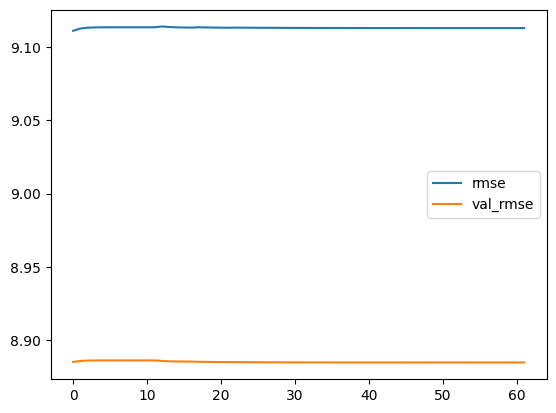

In [49]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

<Axes: >

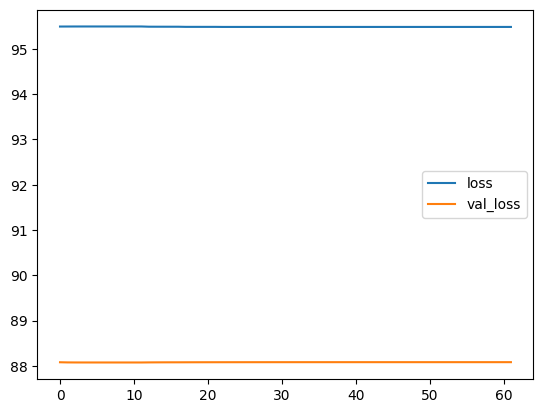

In [50]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()

# Making predictions with our model

To make predictions with our trained model, we can call the [predict method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), passing to it a dictionary of values. The `steps` parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set `steps=1` (setting `steps=None` would also work). Note, however, that if x is a `tf.data` dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [51]:
model.predict([[-73.982683, 40.742104, -73.983766, 40.755174]])

1/1 [==============================] - 0s 128ms/step


array([[11.306651]], dtype=float32)

# Export and deploy our model

Of course, making individual predictions is not realistic, because we can't expect client code to have a model object in memory. For others to use our trained model, we'll have to export our model to a file, and expect client code to instantiate the model from that exported file. 

We'll export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

**Exercise.** Use `tf.saved_model.save` to export the trained model to a Tensorflow SavedModel format. Reference the [documentation for `tf.saved_model.save`](https://www.tensorflow.org/api_docs/python/tf/saved_model/save) as you fill in the code for the cell below.

Next, print the signature of your saved model using the SavedModel Command Line Interface command `saved_model_cli`. You can read more about the command line interface and the `show` and `run` commands it supports in the [documentation here](https://www.tensorflow.org/guide/saved_model#overview_of_commands). 

In [52]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)

tf.saved_model.save(
    model, EXPORT_PATH
)

INFO:tensorflow:Assets written to: ./export/savedmodel/20250513032957/assets


INFO:tensorflow:Assets written to: ./export/savedmodel/20250513032957/assets


In [60]:
!saved_model_cli show \
--tag_set serve \
--signature_def serving_default \
--dir {EXPORT_PATH}

!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_21_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 4)
      name: serving_default_dense_21_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_24'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
./export/savedmodel/20250513032957
./export/savedmodel/20250513032957/fingerprint.pb
./export/savedmodel/20250513032957/variables
./export/savedmodel/20250513032957/variables/variables.data-00000-of-00001
./export/savedmodel/20250513032957/variables/variables.index
./export/savedmodel/20250513032957/saved_model.pb
./export/savedmodel/20250513032957/assets


## Deploy our model to Vertex AI

Finally, we will deploy our trained model to Vertex AI and see how we can make online predicitons. 

In [61]:
PROJECT = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"
MODEL_DISPLAYNAME = f"taxifare-{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

# from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest"
)
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

MODEL_DISPLAYNAME: taxifare-20250513032957


In [65]:
%%bash
# Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
    gsutil ls
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "\nHere are your current buckets:"
    gsutil ls
fi

Bucket exists, let's not recreate it.
gs://qwiklabs-asl-01-19968276eb55/


In [68]:
!gsutil cp -R $EXPORT_PATH gs://$BUCKET/$MODEL_DISPLAYNAME
!echo　gs://$BUCKET/$MODEL_DISPLAYNAME

Copying file://./export/savedmodel/20250513032957/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20250513032957/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20250513032957/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20250513032957/variables/variables.index [Content-Type=application/octet-stream]...
/ [4 files][948.2 KiB/948.2 KiB]                                                
Operation completed over 4 objects/948.2 KiB.                                    
/bin/bash: line 1: echo　gs://qwiklabs-asl-01-19968276eb55/taxifare-20250513032957: No such file or directory


**Exercise.** Complete the code in the cell below to upload and deploy your trained model to Vertex AI using the `Model.upload` method. Have a look at [the documentation](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.Model).

In [71]:
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri="gs://qwiklabs-asl-01-19968276eb55/taxifare-20250513032957",
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI
)

Creating Model
Create Model backing LRO: projects/604342147284/locations/us-central1/models/8112112127335989248/operations/6856501287576403968
Model created. Resource name: projects/604342147284/locations/us-central1/models/8112112127335989248@1
To use this Model in another session:
model = aiplatform.Model('projects/604342147284/locations/us-central1/models/8112112127335989248@1')


In [73]:
MACHINE_TYPE = "n1-standard-2"

endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type=None,
    accelerator_count=None,
)

Creating Endpoint
Create Endpoint backing LRO: projects/604342147284/locations/us-central1/endpoints/8114841115196129280/operations/3233777599821905920
Endpoint created. Resource name: projects/604342147284/locations/us-central1/endpoints/8114841115196129280
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/604342147284/locations/us-central1/endpoints/8114841115196129280')
Deploying model to Endpoint : projects/604342147284/locations/us-central1/endpoints/8114841115196129280
Deploy Endpoint model backing LRO: projects/604342147284/locations/us-central1/endpoints/8114841115196129280/operations/3165801392946282496
Endpoint model deployed. Resource name: projects/604342147284/locations/us-central1/endpoints/8114841115196129280


In [76]:
instance = {"dense_21_input": [-73.982683, 40.742104, -73.983766, 40.755174]}


**Exercise.** Complete the code in the cell below to call prediction on your deployed model for the example you just created in the `instance` variable above.

In [79]:
endpoint.predict(
    [instance]
)

# or
endpoint.predict(
    [[-73.982683, 40.742104, -73.983766, 40.755174]]
)

Prediction(predictions=[[11.3066511]], deployed_model_id='881688478708924416', metadata=None, model_version_id='1', model_resource_name='projects/604342147284/locations/us-central1/models/8112112127335989248', explanations=None)

# Cleanup

When deploying a model to an endpoint for online prediction, the minimum `min-replica-count` is 1, and it is charged per node hour. So let's delete the endpoint to reduce unnecessary charges. Before we can delete the endpoint, we first undeploy all attached models... 

In [ ]:
endpoint.undeploy_all()

...then delete the endpoint.

In [ ]:
endpoint.delete()

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License